In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pickle

The user selects one of several "clustering modes" (each mode being a particular KMeans and UMAP parameter configuration) or a specific number of clusters in a graphical interface. After making a selection, the system:

-   Loads precomputed (cached) UMAP results (two-dimensional/multidimensional image features) from pickle files,
-   Runs or adjusts KMeans for the specified number of clusters,
-   Displays a “recommendations” window, where the user sees a random set of images and can click on any image to find “similar” ones.

When the user clicks on an image, the system determines its cluster, builds a BallTree for all images in that cluster, and finds the nearest neighbors based on the reduced UMAP features. Those “neighbors” are then displayed.

Hence, the project addresses the task of “clustering and retrieving similar images”: the user controls the level of detail (the number of clusters and which UMAP parameters to use), and the interface provides a clear way to explore results (random set + recommendations).

In [3]:
def plot_silhouette_scores(file_paths, cluster_range, params):
# Initialize plot
    x, y = params 
    fig, axes = plt.subplots(x, y, figsize=(18, 12))
    axes = axes.flatten()

    # Loop through each configuration
    for idx, (config, file_path) in enumerate(file_paths.items()):
        n_neighbors, min_dist = config

        # Load UMAP results
        with open(file_path, "rb") as f:
            umap_results = pickle.load(f)

        # Extract UMAP features for the specific configuration
        umap_features = umap_results[(n_neighbors, min_dist)]
        if umap_features is None:
            print(f"UMAP features for n_neighbors={n_neighbors}, min_dist={min_dist} not found in {file_path}.")
            continue

        # Calculate silhouette scores
        silhouette_scores = []
        for n_clusters in cluster_range:
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            cluster_labels = kmeans.fit_predict(umap_features)
            silhouette = silhouette_score(umap_features, cluster_labels)
            silhouette_scores.append(silhouette)

        # Plot the results
        ax = axes[idx]
        ax.plot(cluster_range, silhouette_scores, marker='o', linestyle='--', color='b')
        ax.set_title(f"n_neighbors={n_neighbors}, min_dist={min_dist}")
        ax.set_xlabel("Number of clusters")
        ax.set_ylabel("Silhouette coefficient")
        ax.grid()

    plt.tight_layout()
    plt.show()

I visualized my achievements from the previous project on data clustering analytics. At that time I noticed that for different tasks different results of UMAP and KMeans gave better results. My goal was to choose the best parameters for each type of task

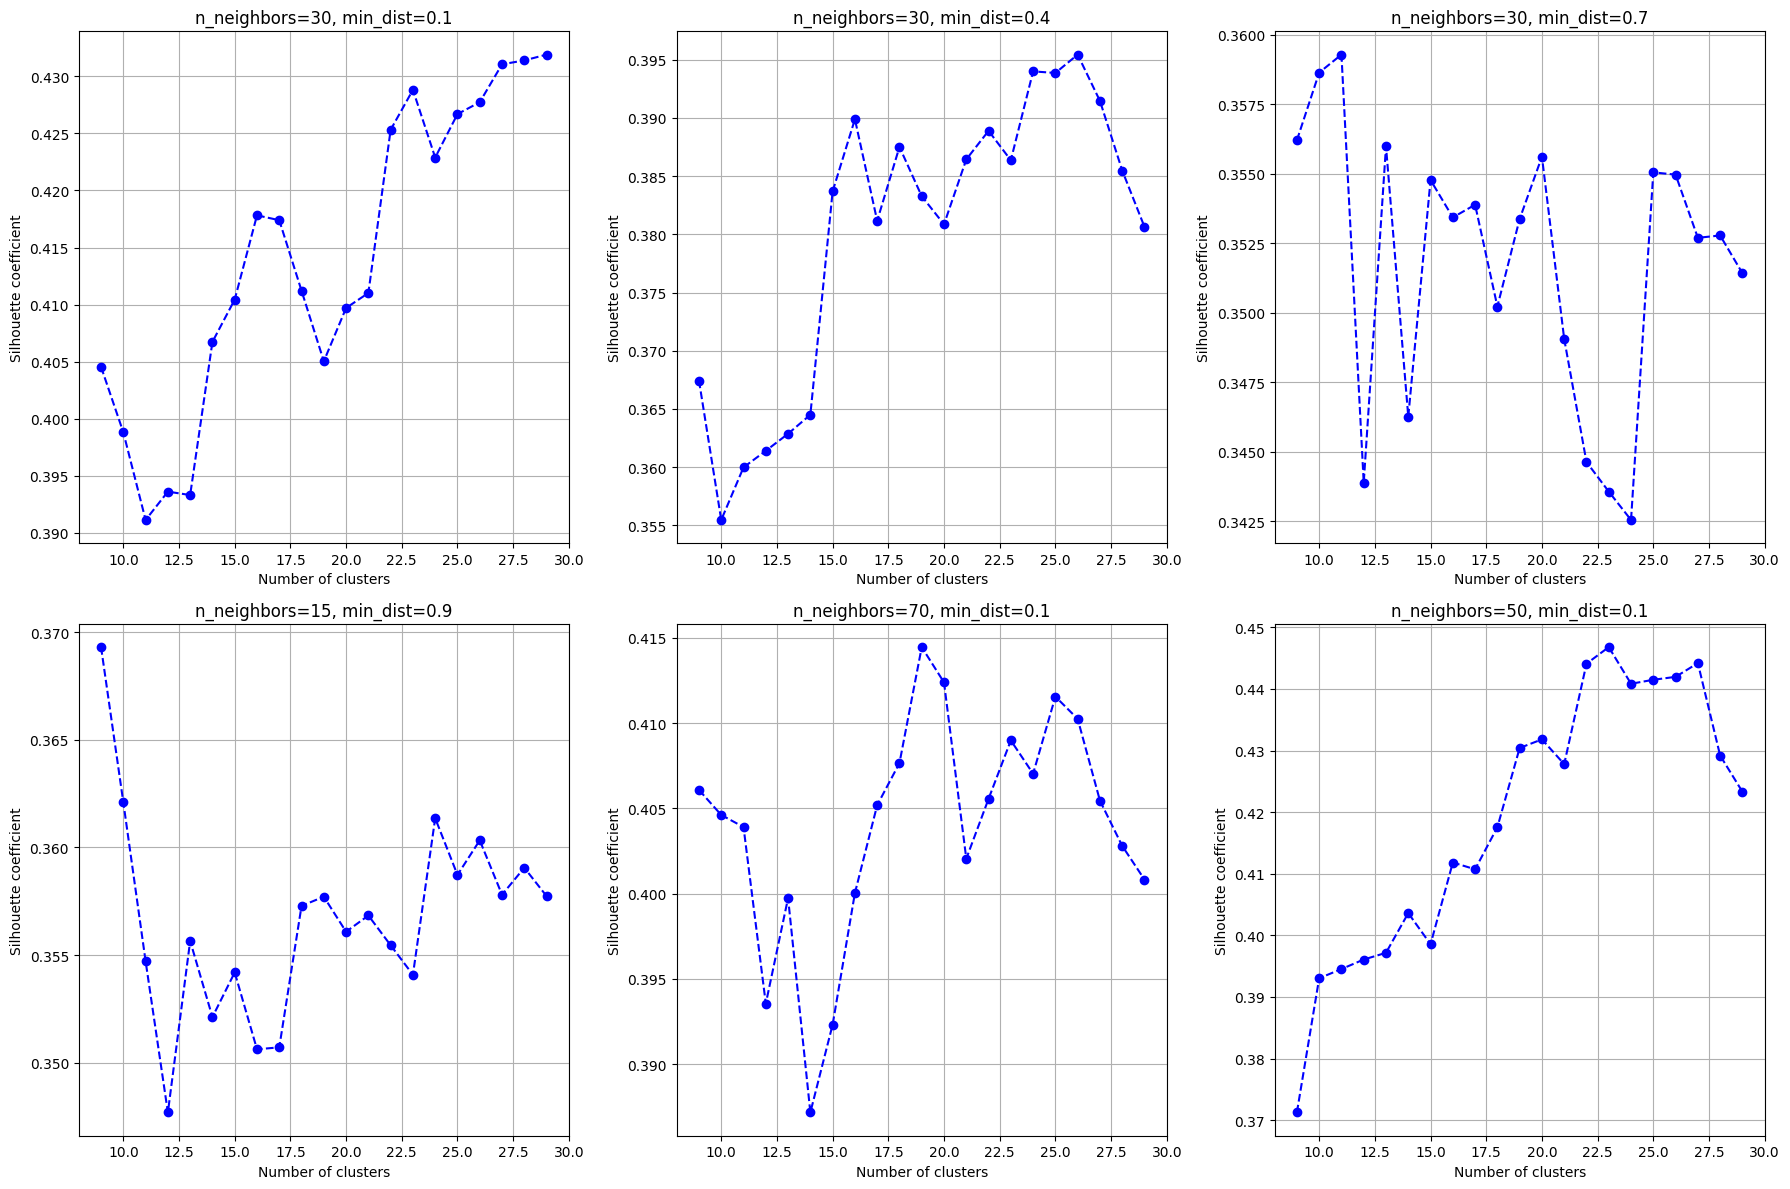

In [4]:

# Define UMAP configurations
umap_configs = [
    (30, 0.1),
    (30, 0.4),
    (30, 0.7),
    (15, 0.9),
    (70, 0.1),
    (50, 0.1)
]

# Range of clusters to evaluate
cluster_range = range(9, 30)

# Path to UMAP results (update this with your actual file paths)
file_paths = {
    (30, 0.1): "data/umap_results_200_30_01-07.pkl",
    (30, 0.4): "data/umap_results_200_30_01-07.pkl",
    (30, 0.7): "data/umap_results_200_30_01-07.pkl",
    (15, 0.9): "data/umap_results_200_15_09.pkl",
    (70, 0.1): "data/umap_results_200_70_01.pkl",
    (50, 0.1): "data/umap_results_200_50_01.pkl"
}
plot_params = (2, 3)

plot_silhouette_scores(file_paths, cluster_range, plot_params)


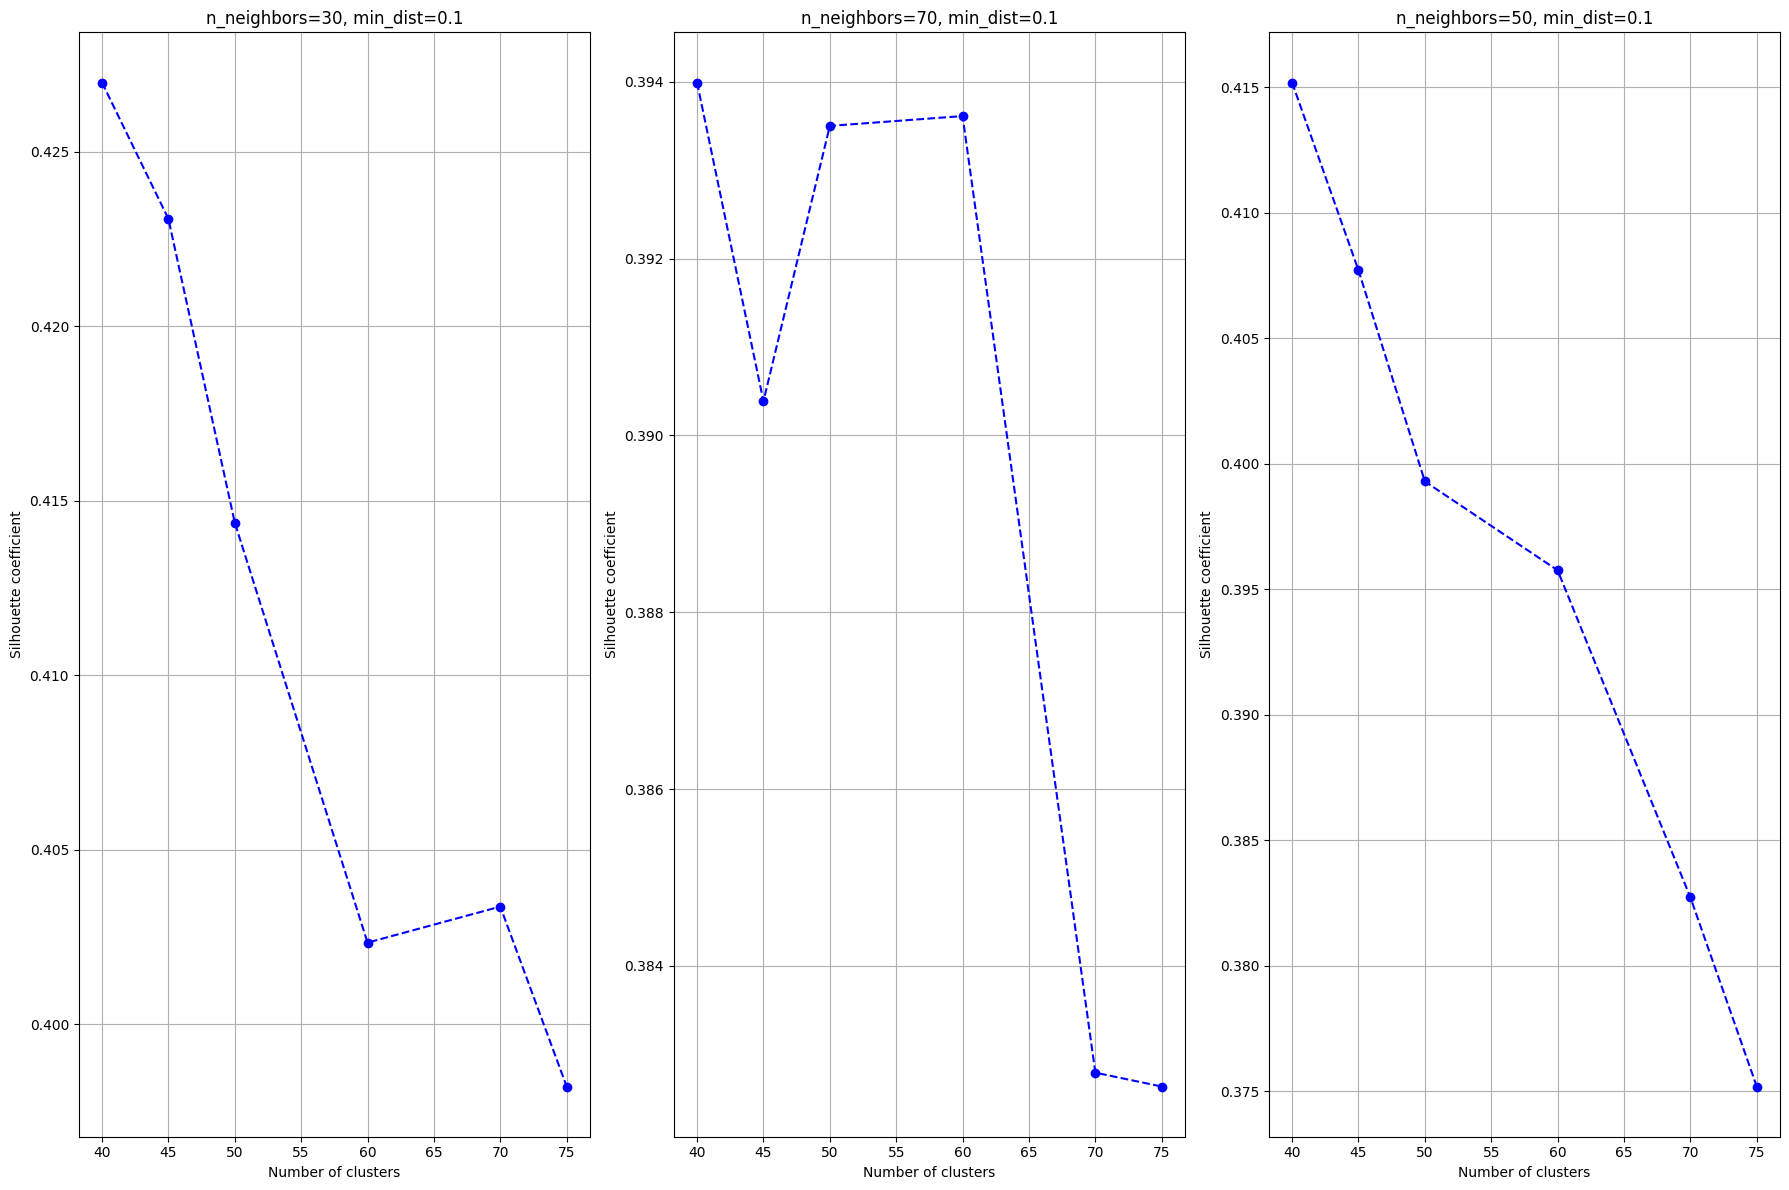

In [77]:
cluster_01 = [40, 45, 50, 60, 70, 75]
file_01 = {
    (30, 0.1): "data/umap_results_200_30_01-07.pkl",
    (70, 0.1): "data/umap_results_200_70_01.pkl",
    (50, 0.1): "data/umap_results_200_50_01.pkl"
}
plot_params = (1, 3)
plot_silhouette_scores(file_01, cluster_01, plot_params)

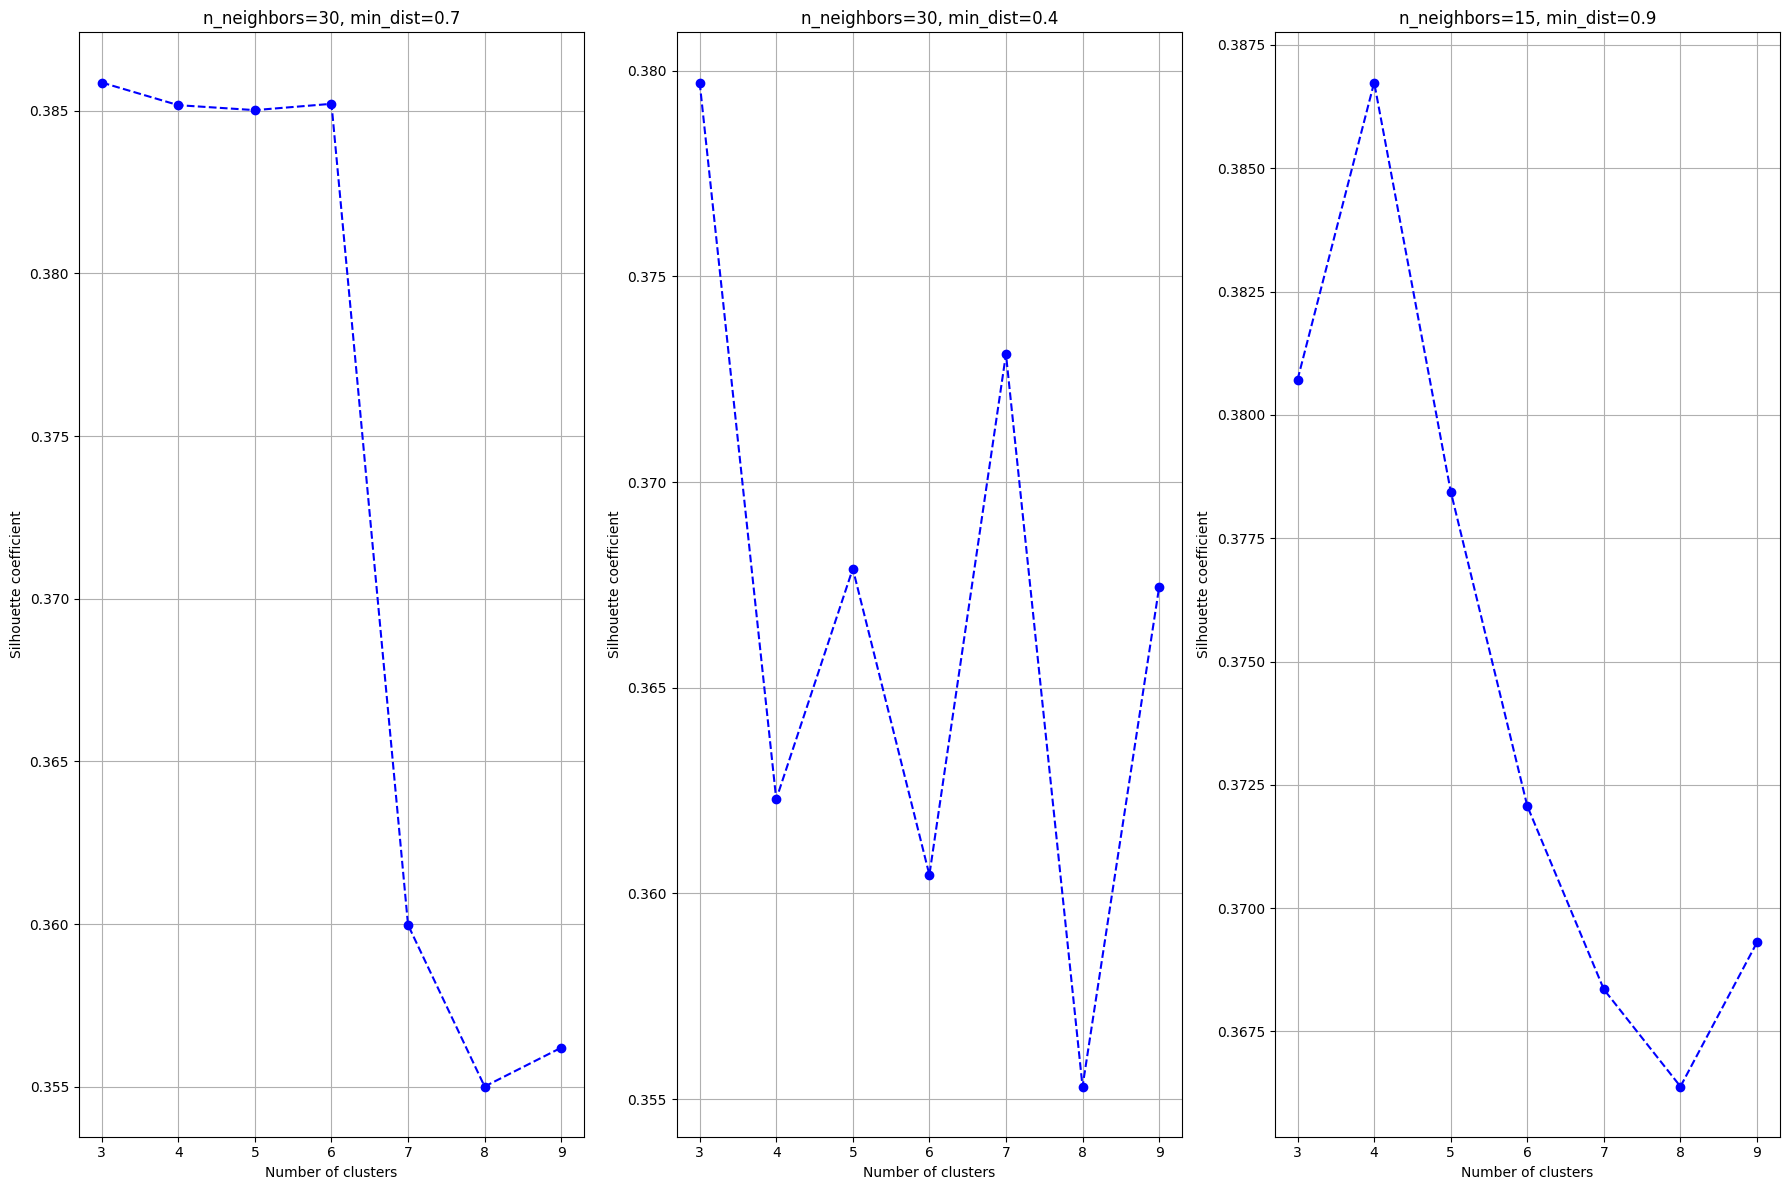

In [78]:
cluster_09 = range(3, 10)
file_09 = {
    (30, 0.7): "data/umap_results_200_30_01-07.pkl",
    (30, 0.4): "data/umap_results_200_30_01-07.pkl",
    (15, 0.9): "data/umap_results_200_15_09.pkl",
}
plot_params = (1, 3)
plot_silhouette_scores(file_09, cluster_09, plot_params)

In [5]:

from sklearn.neighbors import BallTree
import os
import pickle

def collect_image_paths(base_folder):
    image_paths = []
    for root, dirs, files in os.walk(base_folder):
        for file in files:
            # Only consider image files
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
    if not image_paths:
        raise ValueError(f"No images found in the folder: {base_folder}")
    # Sort to match UMAP indices
    return sorted(image_paths)


def load_umap_features(num_clusters, cluster_to_umap_mapping, umap_files):
    umap_params = cluster_to_umap_mapping.get(num_clusters)
    if not umap_params:
        raise ValueError(f"No UMAP configuration found for {num_clusters} clusters.")
    
    umap_file = umap_files.get(umap_params)
    if not umap_file or not os.path.exists(umap_file):
        raise FileNotFoundError(f"No file found for UMAP parameters {umap_params}. Path: {umap_file}")
    
    # Loading data
    with open(umap_file, "rb") as f:
        umap_results = pickle.load(f)
    umap_features = umap_results.get(umap_params)
    if umap_features is None or len(umap_features) == 0:
        raise ValueError(f"UMAP features not found or empty for parameters {umap_params}.")
    
    return umap_features, umap_params


def build_ball_tree(features):
    # Cosine similarity can be approximated by using a normalized approach; here we use Manhattan distance
    return BallTree(features, metric='manhattan')


# Nearest neighbor search
def recommend_images(query_idx, features, tree, num_neighbors=10):
    distances, indices = tree.query([features[query_idx]], k=num_neighbors)
    return indices[0], distances[0]




In [6]:


cluster_to_umap_mapping = {
    3: (30, 0.7), 4: (15, 0.9), 5: (30, 0.7), 6: (30, 0.7), 7: (30, 0.4),
    9: (70, 0.1), 10: (70, 0.1), 11: (70, 0.1),
    15: (30, 0.4), 16: (50, 0.1), 18: (70, 0.1),
    20: (50, 0.1), 23: (50, 0.1), 26: (50, 0.1),
    40: (30, 0.1), 45: (30, 0.1), 55: (70, 0.1), 60: (70, 0.1), 70: (30, 0.1)
}

# Define UMAP configurations
umap_configs = [
    (30, 0.1),
    (30, 0.4),
    (30, 0.7),
    (15, 0.9),
    (70, 0.1),
    (50, 0.1)
]

# Path to UMAP results (update this with your actual file paths)
file_paths = {
    (30, 0.1): "data/umap_results_200_30_01-07.pkl",
    (30, 0.4): "data/umap_results_200_30_01-07.pkl",
    (30, 0.7): "data/umap_results_200_30_01-07.pkl",
    (15, 0.9): "data/umap_results_200_15_09.pkl",
    (70, 0.1): "data/umap_results_200_70_01.pkl",
    (50, 0.1): "data/umap_results_200_50_01.pkl"
}

After collecting the data, I tried to make a simple example of the nearest neighbor search algorithm and visualized the results for clarity. Once I was sure that my algorithm worked, I could start creating a recommendation system with a user interface.

Total images found: 22620
Loaded UMAP features with parameters: (50, 0.1)
Query image belongs to cluster 21.
Number of images in cluster 21: 864
BallTree index built successfully.
Recommended image indices: [21000, 21341, 21349, 21304, 21356, 21301, 21405, 21388, 21351, 21379, 21386, 21326, 21265, 21321, 21295, 21275, 21350, 21374, 21169, 21248]
Distances: [0.         0.00785267 0.0283128  0.03159487 0.03372931 0.03470397
 0.03929162 0.03964186 0.04441905 0.04606867 0.04747903 0.0475316
 0.05657494 0.05706632 0.05776632 0.05859351 0.06154025 0.06295526
 0.06731761 0.06753945]


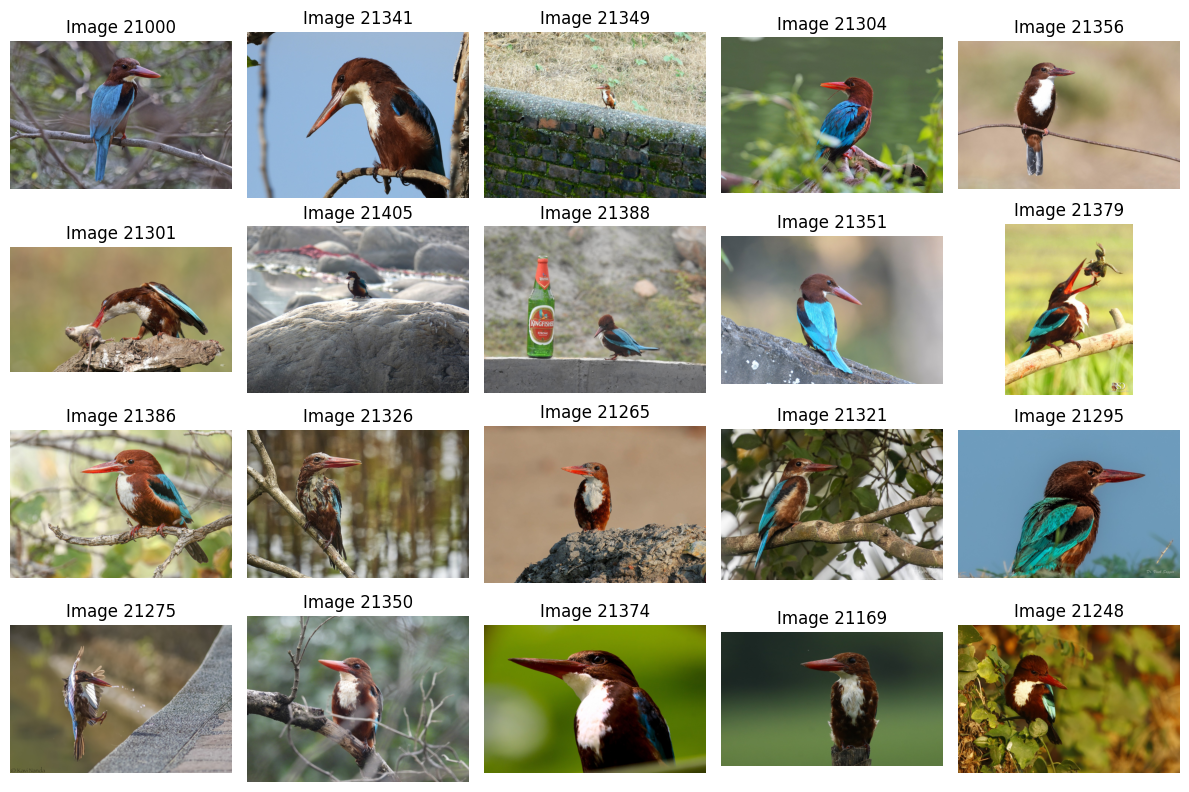

In [7]:
import math
from PIL import Image
import matplotlib.pyplot as plt

num_clusters = 23  # Number of clusters
query_idx = 21000  # Image index for recommendations
number_of_image = 20  # Number of nearest neighbors

try:
    base_folder = "data/training_set"
    image_paths = collect_image_paths(base_folder)
    print(f"Total images found: {len(image_paths)}")

    # Loading UMAP features and their parameters
    umap_features, umap_params = load_umap_features(num_clusters, cluster_to_umap_mapping, file_paths)
    print(f"Loaded UMAP features with parameters: {umap_params}")

    # Clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(umap_features)
    query_cluster = cluster_labels[query_idx]
    print(f"Query image belongs to cluster {query_cluster}.")

    # Filter points of the current cluster
    cluster_indices = [i for i, label in enumerate(cluster_labels) if label == query_cluster]
    if len(cluster_indices) == 0:
        raise ValueError(f"No images found in cluster {query_cluster}.")

    # Create a subset of features for the current cluster
    cluster_features = [umap_features[i] for i in cluster_indices]
    print(f"Number of images in cluster {query_cluster}: {len(cluster_indices)}")

    # Convert query_idx to a local index
    if query_idx not in cluster_indices:
        raise ValueError(f"Query index {query_idx} does not belong to cluster {query_cluster}.")
    local_query_idx = cluster_indices.index(query_idx)

    # Create a BallTree for the current cluster
    tree = build_ball_tree(cluster_features)
    print("BallTree index built successfully.")

    # Check if there are enough points for the search
    if len(cluster_features) < number_of_image:
        number_of_image = len(cluster_features)
        print(f"Reduced number of neighbors to {number_of_image} due to small cluster size.")

    # Nearest neighbor search
    distances, local_indices = tree.query([cluster_features[local_query_idx]], k=number_of_image)
    recommended_indices = [cluster_indices[i] for i in local_indices[0]]
    print(f"Recommended image indices: {recommended_indices}")
    print(f"Distances: {distances[0]}")

    # Visualization
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(recommended_indices):
        x = int(math.sqrt(number_of_image))
        y = int(math.ceil(number_of_image / x))
        plt.subplot(x, y, i + 1)
        plt.title(f"Image {idx}")
        img = Image.open(image_paths[idx])
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

except ValueError as e:
    print(f"ValueError: {e}")
except FileNotFoundError as e:
    print(f"FileNotFoundError: {e}")
except IndexError as e:
    print(f"IndexError: {e}")



All further code is aimed at creating a simplified gradation for the user, because it can be difficult for an ordinary person to choose from such parameters as the number of neighbors, the minimum distance and the number of clusters. I tried to convey in general terms the meaning of separating these types (the titles need to be improved), and also allow the user to simply select a picture from the list and get similar ones and do this again and again until an acceptable result is obtained.

In [8]:
def load_umap_features_by_params(neighbors, min_dist, file_paths):
    """
    Loads UMAP features for the specified (neighbors, min_dist).
    Uses a dictionary `file_paths`, where the key is (neighbors, min_dist)
    and the value is the path to the pickle file.
    Returns (umap_features, (neighbors, min_dist)).
    """
    import pickle
    import os
    
    # 1) Check that file_paths contains the specified key
    if (neighbors, min_dist) not in file_paths:
        raise FileNotFoundError(
            f"No path found for UMAP parameters ({neighbors}, {min_dist})."
        )
    umap_file = file_paths[(neighbors, min_dist)]
    if not os.path.exists(umap_file):
        raise FileNotFoundError(f"File does not exist: {umap_file}")

    # 2) Load the pickle file
    with open(umap_file, "rb") as f:
        umap_results = pickle.load(f)
    # Assume that the pickle file contains a dictionary 
    # whose keys are (neighbors, min_dist)
    if (neighbors, min_dist) not in umap_results:
        raise ValueError(
            f"Key (neighbors, min_dist)=({neighbors}, {min_dist}) not found in pickle {umap_file}"
        )
    umap_features = umap_results[(neighbors, min_dist)]

    # 3) Return the result
    return umap_features, (neighbors, min_dist)


In [9]:
import os
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk
from sklearn.neighbors import BallTree

# Example definition of build_ball_tree (if it's not already defined in your code)
def build_ball_tree(features):
    return BallTree(features, metric='manhattan')

# Example list of image paths (if needed). 
# In practice, you'll likely pass `image_paths` from your existing code.
# image_paths = [...]

class RecommendationApp1:
    def __init__(self, root, indexed_paths, umap_features, cluster_labels):
        """
        indexed_paths  – list of tuples (global_index, path)
        umap_features  – all UMAP features (for the entire dataset)
        cluster_labels – all cluster labels (for the entire dataset)
        """
        self.root = root
        self.indexed_paths = indexed_paths
        self.umap_features = umap_features
        self.cluster_labels = cluster_labels
        self.image_refs_dict = {}

        # Create notebook (tab control)
        self.notebook = ttk.Notebook(root)
        self.notebook.pack(fill="both", expand=True)

        # Tab for starting (random) images
        self.start_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.start_tab, text="Random Images")

        self.display_images(self.indexed_paths, self.start_tab, mode="start")

    def display_images(self, indexed_paths, parent_frame, mode="start", previous_tab=None):
        """
        Displays a set of (global_index, path) in a grid and binds clicks.
        mode: "start" for the initial set of images, "neighbors" if viewing nearest neighbors, etc.
        previous_tab: if in 'neighbors' mode, allows a return to the previous tab.
        """
        # Clear the contents of the parent frame
        for widget in parent_frame.winfo_children():
            widget.destroy()

        frame = ttk.Frame(parent_frame)
        frame.pack(fill="both", expand=True)

        canvas = tk.Canvas(frame)
        scrollbar = ttk.Scrollbar(frame, orient="vertical", command=canvas.yview)
        scrollable_frame = ttk.Frame(canvas)
        scrollable_frame.bind(
            "<Configure>",
            lambda e: canvas.configure(scrollregion=canvas.bbox("all"))
        )
        canvas.create_window((0, 0), window=scrollable_frame, anchor="nw")
        canvas.configure(yscrollcommand=scrollbar.set)

        canvas.pack(side="left", fill="both", expand=True)
        scrollbar.pack(side="right", fill="y")

        columns = 5
        self.image_refs = []
        if parent_frame not in self.image_refs_dict:
            self.image_refs_dict[parent_frame] = []

        for i, (global_idx, img_path) in enumerate(indexed_paths):
            try:
                print("Trying to open:", img_path, "Exists?", os.path.exists(img_path))
                img = Image.open(img_path).resize((250, 250))
                photo = ImageTk.PhotoImage(img)
                self.image_refs_dict[parent_frame].append(photo)
                label = tk.Label(scrollable_frame, image=photo)
                label.grid(row=i // columns, column=i % columns, padx=5, pady=5)

                # On click, call on_image_click
                label.bind(
                    "<Button-1>",
                    lambda e, g=global_idx: self.on_image_click(g, mode, parent_frame)
                )
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

        # "Back" button if needed (for example, in 'neighbors' mode)
        if mode == "neighbors" and previous_tab:
            back_button = tk.Button(
                parent_frame,
                text="Back",
                command=lambda: self.notebook.select(previous_tab)
            )
            back_button.pack(side="bottom", pady=10)

    def on_image_click(self, global_idx, mode, current_tab):
        """
        Called when the user clicks one of the starting/random images.
        1) Determine its cluster.
        2) Gather all indices in that cluster.
        3) Build a BallTree for that cluster.
        4) Find the nearest neighbors.
        5) Create a new tab and display those neighbors.
        """
        print(f"Clicked global index: {global_idx}")

        query_cluster = self.cluster_labels[global_idx]
        print(f"Cluster of clicked image: {query_cluster}")

        # Select all indices from the same cluster
        cluster_indices = [i for i, c in enumerate(self.cluster_labels) if c == query_cluster]
        cluster_features = [self.umap_features[i] for i in cluster_indices]

        # Create a BallTree for this cluster
        tree = build_ball_tree(cluster_features)

        # Find the local index in cluster_indices
        local_query_idx = cluster_indices.index(global_idx)

        # Search for the nearest neighbors (for example, 20)
        distances, local_indices = tree.query([cluster_features[local_query_idx]], k=20)
        neighbors_indices = [cluster_indices[i] for i in local_indices[0]]

        # Assemble (global_index, path) for the neighbors.
        # Make sure `image_paths` is defined or passed appropriately.
        neighbors = [(idx, image_paths[idx]) for idx in neighbors_indices]

        # Create a new tab for neighbors
        neighbors_tab = ttk.Frame(self.notebook)
        self.notebook.add(neighbors_tab, text=f"Neighbors of {global_idx}")

        self.display_images(neighbors, neighbors_tab, mode="neighbors", previous_tab=current_tab)
        self.notebook.select(neighbors_tab)


In [10]:
CATEGORIES = {
    "Low species accuracy - general traits": {
        3:  (30, 0.7),
        4:  (15, 0.9),
        5:  (30, 0.7),
        6:  (30, 0.7),
        7:  (30, 0.4),
    },
    "Medium species accuracy + similar poses": {
        9:  (70, 0.1),
        10: (70, 0.1),
        11: (70, 0.1),
    },
    "Medium species accuracy + similar poses + similar background": {
        15: (30, 0.4),
        16: (30, 0.4),
        18: (70, 0.1),
    },
    "High species accuracy": {
        20: (50, 0.1),
        23: (50, 0.1),
        26: (50, 0.1),
    },
    "Splitting species into subspecies": {
        40: (30, 0.1),
        45: (30, 0.1),
        55: (70, 0.1),
        60: (70, 0.1),
        70: (30, 0.1),
    },
}

file_paths = {
    (30, 0.1): "data/umap_results_200_30_01-07.pkl",
    (30, 0.4): "data/umap_results_200_30_01-07.pkl",
    (30, 0.7): "data/umap_results_200_30_01-07.pkl",
    (15, 0.9): "data/umap_results_200_15_09.pkl",
    (70, 0.1): "data/umap_results_200_70_01.pkl",
    (50, 0.1): "data/umap_results_200_50_01.pkl"
}


In [11]:
import tkinter as tk
from tkinter import ttk

class CategoryClusterSelector(tk.Frame):
    def __init__(self, parent, categories_dict, *args, **kwargs):
        """
        parent: the parent widget (Frame/Tk/etc.)
        categories_dict: the CATEGORIES structure (see above)
                         {
                           "Group_Name": { 3: (30, 0.7), 4: (15, 0.9), ... },
                           ...
                         }
        """
        super().__init__(parent, *args, **kwargs)
        
        self.categories_dict = categories_dict
        
        # List of category names (dictionary keys)
        self.category_names = list(self.categories_dict.keys())
        
        # StringVar to store the selected category
        self.category_var = tk.StringVar()
        # By default, select the first category
        self.category_var.set(self.category_names[0])
        
        # Combobox for selecting the category
        self.category_combo = ttk.Combobox(
            self, 
            textvariable=self.category_var,
            values=self.category_names, 
            state="readonly", 
            width=40
        )
        self.category_combo.pack(side="top", fill="x", padx=5, pady=5)
        
        # Bind an event handler to changes in the category combobox selection
        self.category_combo.bind("<<ComboboxSelected>>", self.on_category_change)

        # Combobox for selecting a specific n_clusters value
        self.cluster_var = tk.IntVar()
        self.cluster_combo = ttk.Combobox(
            self,
            textvariable=self.cluster_var,
            state="readonly",
            width=10
        )
        self.cluster_combo.pack(side="top", fill="x", padx=5, pady=5)
        
        # Initialize the values in the second combobox based on the first (default) category
        self.update_clusters_list()

    def on_category_change(self, event=None):
        """
        When the user selects a different category, update the list of n_clusters.
        """
        self.update_clusters_list()

    def update_clusters_list(self):
        """
        Populates the second combobox with n_clusters values from the selected category.
        """
        cat_name = self.category_var.get()
        clusters_dict = self.categories_dict[cat_name]  # e.g., {3:(30,0.7), 4:(15,0.9), ...}
        cluster_counts = sorted(clusters_dict.keys())
        
        # Set the combobox values
        self.cluster_combo.config(values=cluster_counts)
        if cluster_counts:
            self.cluster_var.set(cluster_counts[0])  # select the first item by default

    def get_selection(self):
        """
        Returns (selected_category_name, n_clusters, (n_neighbors, min_dist)).
        For example:
          ("Low species accuracy - general traits", 4, (15, 0.9))
        """
        cat_name = self.category_var.get()
        n_clust = self.cluster_var.get()  # int
        umap_params = self.categories_dict[cat_name][n_clust]  # (n_neighbors, min_dist)
        return (cat_name, n_clust, umap_params)


In [12]:
import tkinter as tk
from tkinter import ttk
import random
from sklearn.cluster import KMeans


class ModeSelectionApp(tk.Tk):
    def __init__(self, categories, file_paths):
        super().__init__()
        self.title("Select Clustering Mode and UMAP")
        
        self.categories = categories
        self.file_paths = file_paths
        
        # Category + cluster selection widget
        self.selector = CategoryClusterSelector(self, self.categories)
        self.selector.pack(side="top", padx=10, pady=10)
        
        # "Apply" button
        btn_apply = tk.Button(self, text="Apply", command=self.on_apply)
        btn_apply.pack(side="top", pady=5)

        self.log_label = tk.Label(self, text="Make a selection and press 'Apply'")
        self.log_label.pack(side="top", fill="x")

    def on_apply(self):
        """
        Reads the selection (category, n_clusters, (n_neighbors, min_dist)).
        1) Loads UMAP features from file_paths[(neighbors, min_dist)].
        2) Runs KMeans(n_clusters).
        3) Opens the RecommendationApp1 window.
        """
        cat_name, n_clust, (neighbors, min_dist) = self.selector.get_selection()
        
        # Check if we have a file for these (neighbors, min_dist)
        if (neighbors, min_dist) not in self.file_paths:
            msg = f"No UMAP file found for (n_neighbors={neighbors}, min_dist={min_dist})!"
            self.log_label.config(text=msg)
            return
        
        umap_file = self.file_paths[(neighbors, min_dist)]
        
        # 1) LOAD UMAP FEATURES
        umap_features, umap_params = load_umap_features_by_params(neighbors, min_dist, file_paths)

        # 2) Run KMeans
        kmeans = KMeans(n_clusters=n_clust, random_state=42)
        cluster_labels = kmeans.fit_predict(umap_features)

        # 3) Gather 75 random indices (or however many you need)
        global image_paths
        sample_count = min(75, len(image_paths))
        random_indices = random.sample(range(len(image_paths)), sample_count)
        random_indexed_paths = [(idx, image_paths[idx]) for idx in random_indices]

        # Open the recommendation window
        rec_win = tk.Toplevel(self)
        rec_win.title("RecommendationApp1")
        RecommendationApp1(
            rec_win,
            random_indexed_paths,
            umap_features,
            cluster_labels
        )

        msg = (
            f"Selected Category: {cat_name}\n"
            f"clusters={n_clust}, (n_neighbors, min_dist)=({neighbors},{min_dist})\n"
            f"File: {umap_file}\n"
            f"Recommendation window opened."
        )
        self.log_label.config(text=msg)



In [13]:
import tkinter as tk
from tkinter import ttk
import random
from sklearn.cluster import KMeans

class ModeSelectionApp(tk.Tk):
    def __init__(self, categories, file_paths):
        super().__init__()
        self.title("Select Clustering Mode and UMAP")
        
        self.categories = categories
        self.file_paths = file_paths
        
        # Widget to select category + number of clusters
        self.selector = CategoryClusterSelector(self, self.categories)
        self.selector.pack(side="top", padx=10, pady=10)
        
        # "Apply" button
        btn_apply = tk.Button(self, text="Apply", command=self.on_apply)
        btn_apply.pack(side="top", pady=5)

        self.log_label = tk.Label(self, text="Make a selection and click 'Apply'")
        self.log_label.pack(side="top", fill="x")

    def on_apply(self):
        """
        Reads the selection (category, n_clusters, (n_neighbors, min_dist)).
        1) Loads the UMAP features from file_paths[(neighbors, min_dist)].
        2) Runs KMeans(n_clusters).
        3) Opens the RecommendationApp1 window.
        """
        cat_name, n_clust, (neighbors, min_dist) = self.selector.get_selection()
        
        # Check if we have a file for these (neighbors, min_dist)
        if (neighbors, min_dist) not in self.file_paths:
            msg = f"No UMAP file found for (n_neighbors={neighbors}, min_dist={min_dist})!"
            self.log_label.config(text=msg)
            return
        
        umap_file = self.file_paths[(neighbors, min_dist)]
        
        # 1) Load UMAP
        umap_features, umap_params = load_umap_features_by_params(neighbors, min_dist, file_paths)

        # 2) Run KMeans
        kmeans = KMeans(n_clusters=n_clust, random_state=42)
        cluster_labels = kmeans.fit_predict(umap_features)

        # 3) Select 75 random indices (or however many you need)
        global image_paths
        sample_count = min(75, len(image_paths))
        random_indices = random.sample(range(len(image_paths)), sample_count)
        random_indexed_paths = [(idx, image_paths[idx]) for idx in random_indices]

        # Open the recommendation window
        rec_win = tk.Toplevel(self)
        rec_win.title("RecommendationApp1")
        RecommendationApp1(
            rec_win,
            random_indexed_paths,
            umap_features,
            cluster_labels
        )

        msg = (
            f"Selected category: {cat_name}\n"
            f"clusters={n_clust}, (n_neighbors, min_dist)=({neighbors},{min_dist})\n"
            f"File: {umap_file}\n"
            f"Recommendation window opened."
        )
        self.log_label.config(text=msg)


I have prepared a demo version that best illustrates the essence and quality of this project. You can click on the images and get similar ones. The initial set is collected randomly to make sure that the program really works

In [14]:
if __name__ == "__main__":
    import random

    base_folder = "data/training_set"
    num_clusters = 23

    image_paths = collect_image_paths(base_folder)
    umap_features, umap_params = load_umap_features(num_clusters, cluster_to_umap_mapping, file_paths)

    # Clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(umap_features)

    # Generate 75 (or any number) random images
    random_indices = random.sample(range(len(image_paths)), 75)
    random_indexed_paths = [(idx, image_paths[idx]) for idx in random_indices]

    root = tk.Tk()
    root.geometry("1350x800")
    app = RecommendationApp1(
        root,
        random_indexed_paths,  # <- Random set of (global_index, path)
        umap_features,
        cluster_labels
    )
    root.mainloop()


Trying to open: data/training_set\Indian Peacock\ML305069341.jpg Exists? True
Trying to open: data/training_set\Forest Wagtail\ML186512091.jpg Exists? True
Trying to open: data/training_set\White-Breasted Kingfisher\ML21787201.jpg Exists? True
Trying to open: data/training_set\Indian Pitta\ML274019511.jpg Exists? True
Trying to open: data/training_set\Sarus Crane\ML334922541.jpg Exists? True
Trying to open: data/training_set\Sarus Crane\ML240302341.jpg Exists? True
Trying to open: data/training_set\Indian Pitta\ML337237451.jpg Exists? True
Trying to open: data/training_set\Hoopoe\ML333294351.jpg Exists? True
Trying to open: data/training_set\Asian Green Bee-Eater\ML485536031.jpg Exists? True
Trying to open: data/training_set\Common Rosefinch\ML392641161.jpg Exists? True
Trying to open: data/training_set\Common Myna\ML365357391.jpg Exists? True
Trying to open: data/training_set\Ruddy Shelduck\ML92512911.jpg Exists? True
Trying to open: data/training_set\White Wagtail\ML221954021.jpg Exi

This is a modification with a choice of various options, but the result is not always so obvious to me. Common parameters can be objects behind, the presence of a branch, a similar beak, size, and so on. I advise choosing clustering by species differences for 20 or 23 clusters or clustering for 16, 18 clusters. Because there the algorithm also finds obvious and understandable similarities

In [15]:
if __name__ == "__main__":
    # 1) Collect all image paths
    base_folder = "data/training_set"
    image_paths = collect_image_paths(base_folder)

    # 2) Launch the mode selection window
    app = ModeSelectionApp( CATEGORIES, file_paths)
    app.mainloop()

### Conclusion
This project is an interactive Python GUI application (using tkinter and PIL) that enables users to perform a customizable image similarity search with UMAP and KMeans.

Its flexibility lies in the ability to choose different modes (various values of n_clusters and (n_neighbors, min_dist)), which affects how images are ultimately distributed into clusters, as well as the results of the “similar” image search.

The outcome is clearly demonstrated in separate tabs: the user sees images, clicks on any one of them, and instantly receives a list of visually similar images.
Therefore, the final project successfully addresses the task of “clustering (using UMAP + KMeans) and visually searching for similar images” within a convenient graphical interface.